# Validation Figures

This notebook goes through and plots the validation figures. These are specific to the plots used in the conference paper.

## Experiment Overview

## Code

### Packages

In [140]:
import sys
sys.path.insert(0, "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/src")

# Standard packages
import numpy as np
import pandas as pd

# Datasets
from data.make_dataset import DataLoader, load_standard_data, load_high_dim_data, load_labels, get_data

# Experiments

# Features
from features.pca_features import transform_all, transform_individual
from features.analysis import get_stats
from sklearn.preprocessing import StandardScaler
from data.make_dataset import ValidationFloats
from features.build_features import run_input_preprocess, run_input_postprocess, run_output_preprocess, run_output_postprocess, run_split

# ML Models
from sklearn.model_selection import train_test_split
from models.baseline import train_rf_model
import statsmodels.api as smi
from sklearn.metrics import r2_score


# Visualization
from visualization.visualize import plot_mo_stats, plot_geolocations, get_depth_labels
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
plt.style.use('seaborn-poster')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [3]:
def run_experiment():
    
    # Load Data
    dataset = get_data(DataParams)
    print("Input:\n", dataset['ytrain'].min().min(), dataset['ytrain'].max().max())
        
    # Run Inputs Preprocessing
    dataset = run_input_preprocess(ProcessParams, dataset)
    
    # Run Outputs Preprocessing
    # Train Test Split
    dataset = run_split(ProcessParams, dataset)
    
    
    
    
    # Run Inputs PostProcessing
    if ProcessParams.input_std == 'after':
        dataset = run_input_postprocess(ProcessParams, dataset)
    
    # Run Outputs Post Processing
    dataset = run_output_postprocess(ProcessParams, dataset)
    
    print("Output:\n", dataset['ytrain'].min().min(), dataset['ytrain'].max().max())
    return dataset

In [9]:
class DataParams:
    region = 'na'

class ProcessParams:
    n_components = 5
    valid_split = 0.2
    input_std = "before"
    pca_seed = 123
    bootstrap_seed = 111
    std_ouputs = True

dataset = run_experiment()

region = DataParams.region

print('Training:')
print(dataset['Xtrain'].shape, dataset['ytrain'].shape)
print('Validation:')
print(dataset['Xvalid'].shape, dataset['yvalid'].shape)
print('Testing:')
print(dataset['Xtest'].shape, dataset['ytest'].shape)

Input:
 9.99999974737875e-06 0.0227799993008375
Output:
 -8.90301918762965 10.745141882960526
Training:
(2288, 33) (2288, 276)
Validation:
(572, 33) (572, 276)
Testing:
(162, 33) (162, 276)


---
## 2 - Load ML Model

In [10]:
def load_model(save_name):
    # model path
    MODEL_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/models/control/"
    
    # save model
    from joblib import load
    model = load(MODEL_PATH + save_name + '.joblib')
    return model

### 5.1 - Ridge Regression

In [147]:
model_name = 'lr'

# save name
save_name = f"{model_name}_{DataParams.region}"

# load model
model = load_model(save_name)

### 5.3 - (3-Layer) MultiPerceptron Model

In [106]:
model_name = 'mlp'

# save name
save_name = f"{model_name}_{DataParams.region}"

# load model
model = load_model(save_name)

### 5.4 - MO Random Forest Model

In [161]:
model_name = 'morf'

# save name
save_name = f"{model_name}_{DataParams.region}"

# load model
model = load_model(save_name)

---
## 3 - Validation Floats

We have the following validation floats:

**NA**
* 6901486 
* 3902123

**STG**
* 6901472
* 3902121

In [162]:
# make predictions
ypred = model.predict(dataset['Xtest'])

# inverse transform the outputs
ypred = dataset["out_post_trans"].inverse_transform(ypred)
ytest = dataset["out_post_trans"].inverse_transform(dataset['ytest'])

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.1s
[Parallel(n_jobs=28)]: Done 394 tasks      | elapsed:    0.1s
[Parallel(n_jobs=28)]: Done 744 tasks      | elapsed:    0.3s
[Parallel(n_jobs=28)]: Done 1194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=28)]: Done 1500 out of 1500 | elapsed:    0.5s finished


### Average Validation Plots

In [179]:
def plot_validation(y_mu, y_std, ylabels):
    fig, ax = plt.subplots(figsize=(7,5))
    plt.plot(
        y_mu, ylabels, 
        color='black', linewidth=5, label='bBP$_1$, $\mu$')
    plt.fill_betweenx(
        ylabels, 
        y_mu - y_std, 
        y_mu + y_std, 
        interpolate=False, alpha=0.5, color='gray', label='bBP$_1$, $\sigma$'
    )
    return fig, ax

In [180]:
ytest_mu, ypred_mu = ytest.mean(axis=0), ypred.mean(axis=0)
ytest_std, ypred_std = ytest.std(axis=0), ypred.std(axis=0)
ylabels = get_depth_labels()

#### Labels

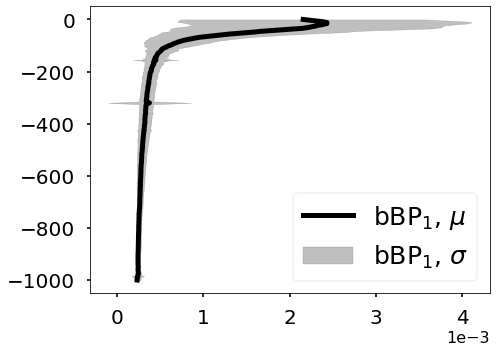

In [187]:
fig, ax = plot_validation(ytest_mu, ytest_std, ylabels)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.tick_params(axis="both", which="minor", labelsize=20)
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
plt.legend(fontsize=25, loc='lower right')
plt.tight_layout()
# fig.savefig(SAVE_PATH + f"stg_y1" + ".png", dpi=200, transparent=True)
plt.show()

#### Predictions

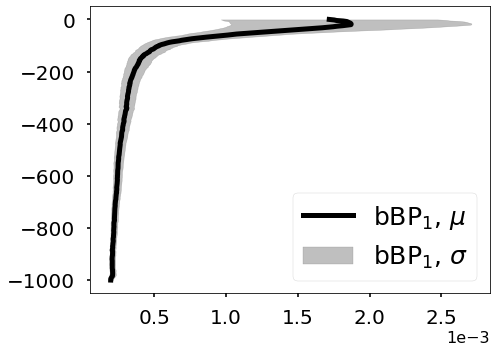

In [188]:
fig, ax = plot_validation(ypred_mu, ypred_std, ylabels)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.tick_params(axis="both", which="minor", labelsize=20)
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
plt.legend(fontsize=25, loc='lower right')
plt.tight_layout()
# fig.savefig(SAVE_PATH + f"stg_y1" + ".png", dpi=200, transparent=True)
plt.show()

### Plot Profiles

In [163]:
# load validation floats
valid_getter = ValidationFloats('na')

# get validation floats
valid_getter.get_validation_floats('na')

# get timeseries
results_df = valid_getter.get_validation_res(ytest, ypred, validation_float=6901486)

results_df.describe()

(162, 2) (162, 276)
0.00014170522838878957 6901486.0 0.00016999999934341794 6901486.0


,n_cycle,Predictions,Labels
count,36984.000000,36984.000000,36984.000000
mean,159.947761,0.000500,0.000586
std,95.997047,0.000526,0.000800
min,3.000000,0.000142,0.000170
25%,80.000000,0.000239,0.000260
50%,149.500000,0.000301,0.000320
75%,195.000000,0.000464,0.000480
max,352.000000,0.003840,0.008750


In [164]:
def df_2_xr(df):
    """Converts the data from a dataframe to an xarray (netcdf format)"""
    # create multiindex data
    df = df.set_index(['n_cycle', 'Depth'])
    
    # convert to xarray
    data = df.to_xarray()
    
    return data

In [165]:
# convert dataframe to xarray
results_xr = df_2_xr(results_df)

In [166]:
def plot_profiles(xr_data, vmin, vmax):
    
    import matplotlib.colors as colors
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    # plot colormesh
    xr_data.T.plot.pcolormesh(
        ax=ax, 
        # colorbar type
        cmap='jet', 
        # colorbar arguments
        cbar_kwargs={'label': ''}, 
        # log scale colorbar
        norm=colors.LogNorm(vmin=vmin, vmax=vmax), 
        
        # min,max
        vmin=vmin, 
        vmax=vmax, 
        
        # don't deal with outliers
        robust=False
    )
    return fig, ax

#### Original

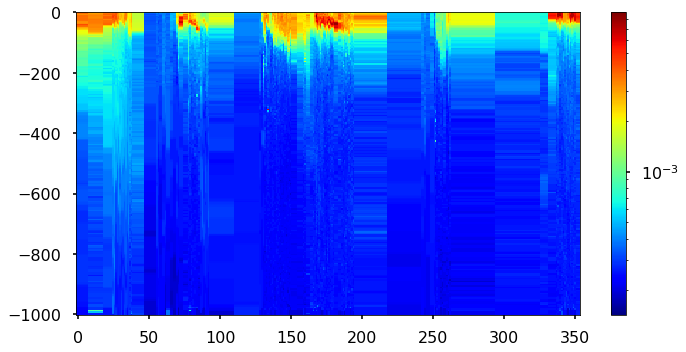

In [167]:
# plot parameters

plot_config = dict()
plot_config['region'] = DataParams.region
plot_config['model'] = model_name
plot_config['save_path']= '/media/disk/erc/papers/2019_ML_OCN/figures/'
plot_config['float'] = 6901486
plot_config['data'] = 'Labels'
plot_config['robust'] = False

# y_val_scat = get_scatter_validation(ypred_, ytest_, plot_config)
vmin = np.minimum(results_xr.Predictions.min(), results_xr.Labels.min())
vmax = np.maximum(results_xr.Predictions.max(), results_xr.Labels.max())

fig, ax = plot_profiles(results_xr.Labels, vmin, vmax)
ax.set_xlabel('')
ax.set_ylabel('')
# fig.savefig(f"{plot_config['save_path']}{plot_config['region']}_y_{plot_config['data']}_heatmap_{plot_config['float']}_pred_{plot_config['model']}")
plt.tight_layout()
plt.show()

#### Predicted

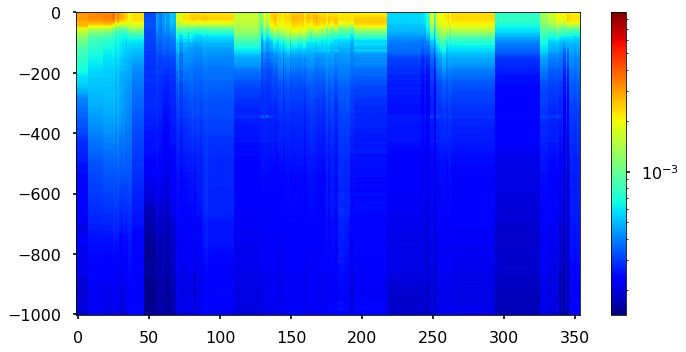

In [168]:
# plot parameters

plot_config = dict()
plot_config['region'] = DataParams.region
plot_config['model'] = model_name
plot_config['save_path']= '/media/disk/erc/papers/2019_ML_OCN/figures/'
plot_config['float'] = 6901486
plot_config['data'] = 'Labels'
plot_config['robust'] = False

# y_val_scat = get_scatter_validation(ypred_, ytest_, plot_config)
vmin = np.minimum(results_xr.Predictions.min(), results_xr.Labels.min())
vmax = np.maximum(results_xr.Predictions.max(), results_xr.Labels.max())

fig, ax = plot_profiles(results_xr['Predictions'], vmin, vmax)
ax.set_xlabel('')
ax.set_ylabel('')
# fig.savefig(f"{plot_config['save_path']}{plot_config['region']}_y_{plot_config['data']}_heatmap_{plot_config['float']}_pred_{plot_config['model']}")
plt.tight_layout()
plt.show()

### Scatter Plot

In [169]:
# Plot Parameters
plot_config = dict()
plot_config['region'] = DataParams.region
plot_config['model'] = model_name
plot_config['save_path']= '/media/disk/erc/papers/2019_ML_OCN/figures/'
plot_config['float'] = 6901486

#### Statistics

In [170]:
def mapd(ypred, y):
    return np.median(np.abs(ypred - y) / y)

In [171]:
# =================
# Statistics
# =================

# R2 of log10 transform
plot_config['r2'] = r2_score(np.log10(results_df['Predictions']), np.log10(results_df['Labels']))

# MAPD% of original data
plot_config['mapd'] = mapd(results_df['Predictions'], results_df['Labels'])

In [172]:
# Linear Regression on log10 results
stat_mod = smi.OLS(np.log10(results_df['Labels']), np.log10(results_df['Predictions']))

lin_res = stat_mod.fit()
r2_val = lin_res.rsquared

# slope coefficient
plot_config['slope'] = lin_res.params[0]

print(lin_res.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Labels   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          4.343e+07
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        10:03:32   Log-Likelihood:                          32932.
No. Observations:               36984   AIC:                                 -6.586e+04
Df Residuals:                   36983   BIC:                                 -6.585e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

#### Figure

In [173]:
def plot_scatter(results_df):
    

    # identity line
    id_line = np.logspace(-4, -2, 100)

    fig, ax = plt.subplots(figsize=(10,7))

    # =================================
    # Plot Data
    # =================================

    # scatter points
    results_df.plot.scatter(ax=ax, x='Predictions', y='Labels', c='Depth', logx=True, logy=True, cmap='winter')

    # identity line
    ax.plot(id_line, id_line, linewidth=5, color='black')
  
    return fig, ax

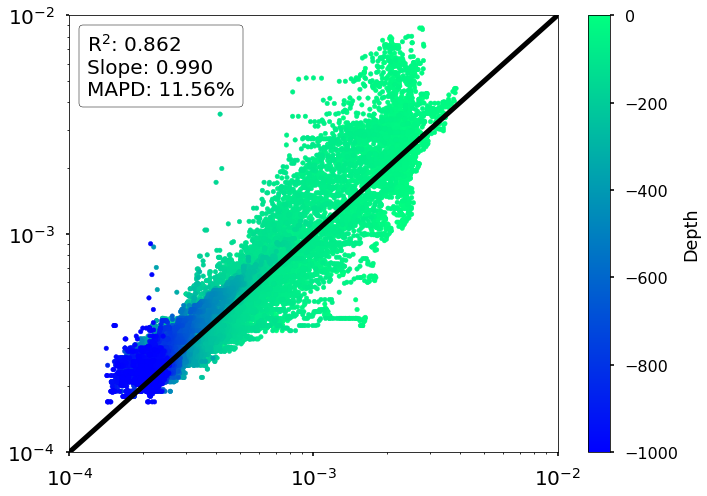

In [174]:
# ==================
# Scatter Points
# ==================
fig, ax = plot_scatter(results_df)

# ====================
# results text
# ====================
at = AnchoredText(f"R$^2$: {plot_config['r2']:.3f}\nSlope: {plot_config['slope']:.3f}\nMAPD: {plot_config['mapd']:.2%}",
                  prop=dict(size=15, fontsize=20), frameon=True,
                  loc='upper left',

                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
ax.autoscale(enable=True, axis='both', tight=True)

# ==================
# Modify Limits
# ==================

ax.set_xlim(0.0001, 0.01)
ax.set_ylim(0.0001, 0.01)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=12)

# extras
plt.tight_layout()

# save plot
# fig.savefig(SAVE_PATH + f'{plot_config["region"]}_m{plot_config["model"]}_f{plot_config["float"]}_depth' + '.png')

# Show Plot
plt.show()  